In [1]:
# import library
import os
import pandas as pd
import numpy as np
import warnings
import zipfile
import seaborn as sns
import yaml
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

tqdm.pandas()
warnings.filterwarnings('ignore')

### Load data

In [2]:
_zipfile_train = zipfile.ZipFile('../local/train.tsv.zip')
_zipfile_test = zipfile.ZipFile('../local/test.tsv.zip')

In [3]:
with _zipfile_train.open('train.tsv') as f:
    df_train = pd.read_csv(f,delimiter='\t')
with _zipfile_test.open('test.tsv') as f:
    df_test = pd.read_csv(f,delimiter='\t')

In [4]:
cwd = os.getcwd()
with open('configuration.yaml') as f:
    lib_dir = yaml.load(f, yaml.BaseLoader).get('library_directory')
os.chdir(lib_dir)
import func_nlp as func
os.chdir(cwd)

### EDA

In [5]:
df_train.columns, df_test.columns

(Index(['PhraseId', 'SentenceId', 'Phrase', 'Sentiment'], dtype='object'),
 Index(['PhraseId', 'SentenceId', 'Phrase'], dtype='object'))

In [6]:
# drop unnecessary columns
df_train.drop(columns=['PhraseId', 'SentenceId'], inplace=True)
df_train.shape

(156060, 2)

In [7]:
df_train[df_train['Sentiment'] == 2].shape

(79582, 2)

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

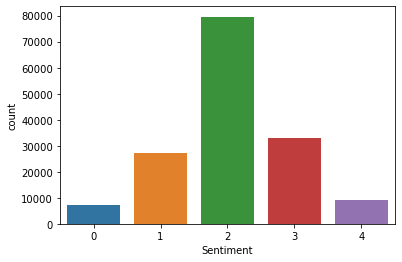

In [8]:
sns.countplot(df_train['Sentiment'])

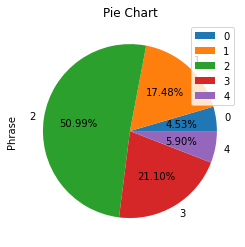

In [9]:
df_train.groupby(['Sentiment']).count()\
.reset_index(drop=True)\
.plot.pie(y='Phrase', autopct='%.2f%%', title='Pie Chart')
plt.show()

### Upsampling

### Word preprocessing

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [11]:
tf.random.set_seed(0)

In [12]:
# special handle on words
df_train['Phrase'] = df_train['Phrase'].progress_apply(lambda x: func.clean_text(x))
df_test['Phrase'] = df_test['Phrase'].progress_apply(lambda x: func.clean_text(x))

  0%|          | 0/156060 [00:00<?, ?it/s]

  0%|          | 0/66292 [00:00<?, ?it/s]

In [13]:
tokenizer = Tokenizer(num_words = 20000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['Phrase'])
word_index = tokenizer.word_index
word_sequences = tokenizer.texts_to_sequences(df_train['Phrase'])
x_test = tokenizer.texts_to_sequences(df_test['Phrase'])
print('Number of unique word: {}'.format(len(word_index)-1))

Number of unique word: 15273


In [14]:
maxlen = 50
# specify the length of sentence within 50 words
# keep zero at the end of sentence if not 50 words
# truncate the end of words if longer than 50
x_train = pad_sequences(word_sequences, maxlen=maxlen, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=maxlen, padding='post', truncating='post')

In [15]:
y_train = np.array(pd.get_dummies(df_train['Sentiment']))

### Model

In [55]:
import math
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Embedding, GRU, Dropout, Bidirectional, GlobalMaxPooling1D, Input, concatenate, BatchNormalization, Conv1D

In [64]:
nlp_input = Input(shape = (maxlen, ), name = 'input_words')
nlp = Embedding(input_dim = len(word_index) + 1, 
                  output_dim = 16,
                  input_length = maxlen,
                  mask_zero = True)(nlp_input)
nlp = Bidirectional(GRU(128, input_shape=(-1,800), recurrent_dropout=.1, dropout=.1, return_sequences=True))(nlp)
nlp = Conv1D(64, 2, activation='relu')(nlp)
nlp = GlobalMaxPooling1D()(nlp)
nlp = Dropout(.2)(nlp)
nlp = Dense(64, activation='relu')(nlp)
nlp = BatchNormalization()(nlp)
nlp = Dense(5, activation='softmax')(nlp)
nlp = Model(inputs = nlp_input, outputs = nlp)

model = Model(inputs=[nlp.input], 
              outputs=nlp.output,
              name='final_model')

In [65]:
# model configuration
epochs = 15
batch_size = 128
verbose = 1
patience = 2
lr_rate = 1e-3
# when fitting a keras model, decay every 1000 steps with a base of .5
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    lr_rate,
    decay_steps=1000,
    decay_rate=.75,
    staircase=False)
optimizer = tf.keras.optimizers.Adam(lr_schedule)
loss = tf.keras.losses.categorical_crossentropy

In [66]:
def step_decay(epoch):
    # Credit: https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/
    # Drop-Based Learning Rate Schedule    
    initial_lrate = lr_rate
    drop = .075
    epochs_drop = 20.
    # new_lr_rate = initial_lrate * math.pow(drop, ((1+epoch*2)/epochs_drop))
    new_lr_rate = lr_rate * drop ** (epoch / epochs_drop)
    if new_lr_rate <= initial_lrate/100: new_lr_rate = initial_lrate/100
    return new_lr_rate

In [67]:
model.summary()

Model: "final_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_words (InputLayer)     [(None, 50)]              0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 50, 16)            244400    
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 50, 256)           112128    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 49, 64)            32832     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 64)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                

In [68]:
model.compile(loss = loss, optimizer = optimizer,
             metrics = ['acc'])

In [69]:
# learning rate decay 
lrate = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)
# stop the trainng if validation loss is not improved for 3 rounds
val_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)

In [70]:
%%time
# find proper learning rate first
history = model.fit(x = [x_train], y = y_train,
                   batch_size = batch_size,
                   epochs = epochs, 
                   callbacks=[val_callback, 
                              #lrate
                             ],
                   validation_split=.2, 
                   verbose=verbose)

Epoch 1/15
976/976 [==============================] - 304s 311ms/step - loss: 0.9971 - acc: 0.6002 - val_loss: 0.9906 - val_acc: 0.6004
Epoch 2/15
976/976 [==============================] - 311s 318ms/step - loss: 0.7898 - acc: 0.6769 - val_loss: 0.9858 - val_acc: 0.6085
Epoch 3/15
976/976 [==============================] - 313s 321ms/step - loss: 0.7245 - acc: 0.7026 - val_loss: 0.9912 - val_acc: 0.6072
Epoch 4/15
976/976 [==============================] - 314s 321ms/step - loss: 0.6798 - acc: 0.7195 - val_loss: 1.0021 - val_acc: 0.6078
Wall time: 20min 49s


In [71]:
optimizer.get_config()

{'name': 'Adam',
 'learning_rate': {'class_name': 'ExponentialDecay',
  'config': {'initial_learning_rate': 0.001,
   'decay_steps': 1000,
   'decay_rate': 0.75,
   'staircase': False,
   'name': None}},
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

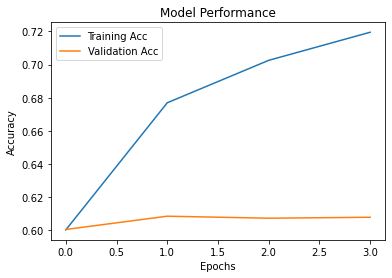

In [72]:
hist = pd.DataFrame(history.history)
hist['epochs'] = history.epoch
plt.figure()
plt.plot(hist['epochs'], hist['acc'], label='Training Acc')
plt.plot(hist['epochs'], hist['val_acc'], label='Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Performance')
plt.legend()
plt.show()

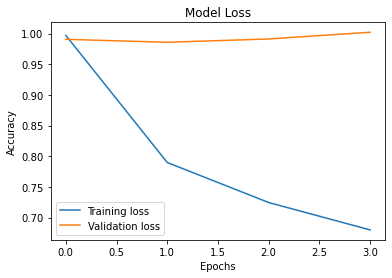

In [73]:
plt.figure()
plt.plot(hist['epochs'], hist['loss'], label='Training loss')
plt.plot(hist['epochs'], hist['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Loss')
plt.legend()
plt.show()

In [74]:
# store trained model
filename = 'fifthSubmission.h5'
model.save(filename)

In [75]:
%%time
# create submission
df_test['y_pred'] = np.argmax(model.predict([x_test]), axis=1)
submission = df_test[['PhraseId', 'y_pred']].rename(columns={'y_pred': 'Sentiment'})
submission.to_csv('fifthSubmission.csv', index=False, header=True)

Wall time: 54.4 s
